# 作業 : 比較 transformer 和 RNN - attention 效果 以及可視化 transformer 
- 了解 transformer 的效能
- 可視化 transformer 以更了解 transformer 內部結構

### 如果之前的範例程式有跑完訓練 這邊的程式應該可以順利執行
### 請注意後面標註 [作業重點] 之處 並且注意觀察比較程式輸出結果
### 如 [作業重點] 比較 transformer 和 RNN - attention 效果

# [作業目標]
- 比較  transformer 和 RNN - attention 效果
- 可視化 transformer 內部參數

# [作業重點]
- 比較 transformer 和 RNN - attention 效果
  - 模型效果
  - 訓練速度
  - 模型大小
- 可視化 transformer 以更了解 transformer 內部學習結果


In [1]:
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

先連接自己的GOOGLE DRIVE 為了要儲存資料和訓練模型

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 使用torchtext TabularDataset 讀資料
### 並且分別讀取訓練時儲存的 src and target 的 字元表
### 如果對torchtext 不太熟習的人可以回去複習一下
### 這邊有用到一個有名的 NLP套件 spacy 幫我們做 英文tokenize

In [3]:
def build_en_vocab(sents, tokenizer):
    counter = Counter()
    for sent in sents:
        counter.update(tokenizer(sent))
        
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


def build_cmn_vocab(sents):
    counter = Counter()
    for sent in sents:
        counter.update([word for word in sent if sent.strip()])
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    

def build_vocab(filepath, en_tokenizer):
    en_sents = []
    cmn_sents = []
    
    data = pd.read_csv(filepath, names=['en', 'cmn'])
    for i in range(data.shape[0]):
        en, cmn = data.iloc[i]
        en = re.sub(r"([.!?])", r" \1", en)
        cmn = re.sub(r'[^\u4e00-\u9fa5A-Za-z0-9。？]', ' ', cmn)

        en_sents.append(en)
        cmn_sents.append(cmn)
        
    cmn_vocab = build_cmn_vocab(cmn_sents)
    en_vocab = build_en_vocab(en_sents, en_tokenizer)    
    
    return en_vocab, cmn_vocab

data_dir = '/content/drive/My Drive/DL_NLP_marathon/data/'
model_dir = '/content/drive/My Drive/DL_NLP_marathon/model/Day27_transformer/'

# 使用 spacy 的英文模型幫我們做tokenize
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
try:
    # 讀取之前儲存的 vocabulary
    cmn_vocab = torch.load(model_dir + 'cmn_vocab.pt')
    en_vocab = torch.load(model_dir + 'en_vocab.pt')
    print("Load previous vocab.")
except:
    train_filepath = data_dir + 'train.csv'
    en_vocab, cmn_vocab = build_vocab(train_filepath, en_tokenizer)
    print("Rebuild vocabs.")

print ("中文語料的字元表長度: " , len(cmn_vocab) , ", 英文的字元表長度: " ,len(en_vocab))

Load previous vocab.
中文語料的字元表長度:  2712 , 英文的字元表長度:  4247


In [4]:
def data_process(filepath):
    raw_data = pd.read_csv(filepath, names=['en', 'cmn'])
    data = []
    for (raw_cmn, raw_en) in zip(raw_data['cmn'], raw_data['en']):
        cmn_tensor_ = torch.tensor([cmn_vocab[token] for token in raw_cmn], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long)
        data.append((cmn_tensor_, en_tensor_))
    return data

# train_filepath = data_dir + 'train.csv'
val_filepath = data_dir + 'val.csv'
test_filepath = data_dir + 'test.csv'

# train_data = data_process(train_filepath)
val_data = data_process(val_filepath)
test_data = data_process(test_filepath)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
PAD_IDX = cmn_vocab['<pad>']
BOS_IDX = cmn_vocab['<bos>']
EOS_IDX = cmn_vocab['<eos>']

def generate_batch(data_batch):
    en_batch, cmn_batch = [], []
    cmn_lens = []
    for (cmn_item, en_item) in data_batch:
        cmn_seq = torch.cat([torch.tensor([BOS_IDX]), cmn_item, torch.tensor([EOS_IDX])], dim=0)
        cmn_batch.append(cmn_seq)
        cmn_lens.append(len(cmn_seq))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))

    sorted_idx = sorted(range(len(cmn_lens)), key=lambda k: cmn_lens[k], reverse=True)
    cmn_batch = [cmn_batch[i] for i in sorted_idx]
    en_batch = [en_batch[i] for i in sorted_idx]
    
    cmn_batch = pad_sequence(cmn_batch, padding_value=PAD_IDX, batch_first=True)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=True)

    return cmn_batch, en_batch

# train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
#                         shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

# Transformer 本體
## 和之前版本完全相同 只是去除 comments
## 簡單版本 共 172 行

In [6]:
class TransformerEncoder(nn.Module):
  """ Transformer 的 encoder """
  def __init__(self, hidden_dim, feedforward_dim, n_enc_layers, n_attn_heads, dropout, src_voca_length, max_pos_length , device):
      super().__init__()
      self.device = device
      self.src_tok_embedding = nn.Embedding(src_voca_length , hidden_dim ) 
      self.src_pos_embedding = nn.Embedding(max_pos_length, hidden_dim) 
      self.transformer_encoder_layers = nn.ModuleList([TransformerEncoderLayer(hidden_dim, 
                                            feedforward_dim,
                                            n_enc_layers,
                                            n_attn_heads, 
                                            dropout, 
                                            device) for _ in range(n_enc_layers)])
      self.dropout = nn.Dropout(dropout)

  def forward(self, src_sentence, src_mask):
        batch_size = src_sentence.shape[0]
        src_len = src_sentence.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        src_sentence = self.dropout(self.src_tok_embedding(src_sentence)  + self.src_pos_embedding(pos))
        for layer in self.transformer_encoder_layers:
            src_sentence , encoder_self_attention = layer(src_sentence, src_mask)
        return src_sentence , encoder_self_attention

class TransformerEncoderLayer(nn.Module):
  def __init__(self, hidden_dim , feedforward_dim, n_enc_layers, n_attn_heads, dropout , device):
    super().__init__()
    self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim,n_attn_heads,dropout,device)
    self.self_attn_layernorm = nn.LayerNorm(hidden_dim)
    self.feedforward_sublayer = PosFeedForwardSubLayer(hidden_dim,feedforward_dim,dropout)
    self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, src_embedding, src_mask):
    _src,  encoder_self_attention = self.self_attention_sublayer(src_embedding, src_embedding, src_embedding, src_mask)
    src_embedding = self.self_attn_layernorm(src_embedding + self.dropout(_src))
    _src = self.feedforward_sublayer(src_embedding)
    src_embedding = self.feedforward_layernorm(src_embedding + self.dropout(_src))
    return src_embedding , encoder_self_attention

class MultiHeadAttentionSubLayer(nn.Module):
  def __init__(self, hidden_dim , n_attn_heads, dropout, device):
    super().__init__()
    assert hidden_dim % n_attn_heads ==0
    self.hidden_dim = hidden_dim
    self.n_attn_heads = n_attn_heads
    self.head_dim = hidden_dim // n_attn_heads
    self.full_conn_q = nn.Linear(hidden_dim, hidden_dim)
    self.full_conn_k = nn.Linear(hidden_dim, hidden_dim)
    self.full_conn_v = nn.Linear(hidden_dim, hidden_dim)
    self.full_conn_o = nn.Linear(hidden_dim, hidden_dim)
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query_input, key_input, value_input, mask = None):
    batch_size = query_input.shape[0]
    Q = self.full_conn_q(query_input)
    K = self.full_conn_k(key_input)
    V = self.full_conn_v(value_input)
    def split_attention(Q, K, V):
      Q = Q.view(batch_size, -1, self.n_attn_heads, self.head_dim)
      K = K.view(batch_size, -1, self.n_attn_heads, self.head_dim)
      V = V.view(batch_size, -1, self.n_attn_heads, self.head_dim)
      return Q , K , V

    def seperate_heads(Q, K, V):
      Q = Q.permute(0, 2, 1, 3) # (batch_size, self.n_heads , query len , self.head_dim)
      K = K.permute(0, 2, 1, 3) # (batch_size, self.n_heads , key len , self.head_dim)
      V = V.permute(0, 2, 1, 3) # (batch_size, self.n_heads , value len , self.head_dim)
      return Q , K , V

    Q, K, V = split_attention(Q, K, V)
    Q, K, V = seperate_heads (Q, K, V)
    scaled_dot_product_similarity = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
    if mask is not None:
      scaled_dot_product_similarity = scaled_dot_product_similarity.masked_fill(mask == 0, -1e10)
    attention = torch.softmax(scaled_dot_product_similarity, dim = -1)
    x = torch.matmul(self.dropout(attention), V)
    x = x.permute(0, 2, 1, 3).contiguous()   
    x = x.view(batch_size, -1, self.hidden_dim)    
    x = self.full_conn_o(x)
    return x, attention

class PosFeedForwardSubLayer(nn.Module):
  def __init__(self, hidden_dim, ff_dim, dropout):
    super().__init__()
    self.full_conn_1 = nn.Linear(hidden_dim, ff_dim)
    self.full_conn_2 = nn.Linear(ff_dim,  hidden_dim)
    self.dropout = nn.Dropout(dropout)
    
  def forward(self, x):
    x = self.dropout(torch.relu(self.full_conn_1(x)))
    x = self.full_conn_2(x)
    return x

class TransformerDecoder(nn.Module):
  def __init__(self, hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads, dropout, dec_voca_length, max_pos_length , device , skip_encoder_attn = False):
    super().__init__()
    self.device = device
    self.dec_tok_embedding = nn.Embedding(dec_voca_length, hidden_dim )
    self.dec_pos_embedding = nn.Embedding(max_pos_length, hidden_dim)
    self.transformer_decoder_layers = nn.ModuleList([TransformerDecoderLayer(hidden_dim,
                                          feedforward_dim, 
                                          n_dec_layers,
                                          n_attn_heads,
                                          dropout, 
                                          device, skip_encoder_attn) for _ in range(n_dec_layers)])
    self.full_conn_out = nn.Linear(hidden_dim, dec_voca_length)
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, dec_seq, enc_hidden , dec_mask, enc_mask):       
    batch_size = dec_seq.shape[0]
    dec_len = dec_seq.shape[1]
    pos = torch.arange(0, dec_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)                        
    dec_seq = self.dropout(self.dec_tok_embedding(dec_seq)  + self.dec_pos_embedding(pos))
    for layer in self.transformer_decoder_layers:
      dec_seq, encoder_decoder_attention , decoder_self_attention = layer(dec_seq, enc_hidden, dec_mask, enc_mask)   
    output = self.full_conn_out(dec_seq)      
    return output, encoder_decoder_attention , decoder_self_attention

class TransformerDecoderLayer(nn.Module):
  def __init__(self, hidden_dim , feedforward_dim, n_dec_layers, n_attn_heads, dropout , device , skip_encoder_attn = False):
    super().__init__()
    self.skip_encoder_attn = skip_encoder_attn 
    self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
    self.self_attn_layernorm = nn.LayerNorm(hidden_dim)
    if not skip_encoder_attn:
      self.encoder_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
      self.encoder_attn_layernorm = nn.LayerNorm(hidden_dim)
    self.positionwise_feedforward = PosFeedForwardSubLayer(hidden_dim,feedforward_dim ,dropout)
    self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout)     

  def forward(self, dec_seq, enc_hidden , dec_mask, enc_mask):
    _dec_seq, decoder_self_attention = self.self_attention_sublayer(dec_seq, dec_seq, dec_seq, dec_mask)
    dec_seq = self.self_attn_layernorm(dec_seq + self.dropout(_dec_seq))      
    if not self.skip_encoder_attn:
      _dec_seq, encoder_decoder_attention = self.encoder_attention_sublayer(dec_seq, enc_hidden, enc_hidden, enc_mask)
      dec_seq = self.encoder_attn_layernorm(dec_seq + self.dropout(_dec_seq))
    else:
      encoder_decoder_attention = None
    _dec_seq = self.positionwise_feedforward(dec_seq)
    dec_seq = self.feedforward_layernorm(dec_seq + self.dropout(_dec_seq))
    return dec_seq, encoder_decoder_attention , decoder_self_attention
        
class Transformer(nn.Module):
  def __init__(self,encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask

  def make_trg_mask(self, trg):
    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    trg_len = trg.shape[1]    
    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
    trg_mask = trg_pad_mask & trg_sub_mask
    return trg_mask

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src , encoder_self_attention = self.encoder(src, src_mask)
    output, encoder_decoder_attention , decoder_self_attention = self.decoder(trg, enc_src, trg_mask, src_mask)
    return output, encoder_decoder_attention , encoder_self_attention ,  decoder_self_attention

# 實際建立模型
- 設定重要參數 要和之前訓練時一樣
  - cmn_vocab 中文 vocab , en_vocab 英文 vocab
  - 建立一個 hidden embedding 256，三層encoder layer, 三層decoder layer，各八個attention heads
  - position wise feedforward 中間層 512 dropout 0.1 learning rate: 0.0005
  - 最長句長 40


In [7]:
INPUT_DIM = len(cmn_vocab)
OUTPUT_DIM = len(en_vocab)
MAX_SENT_LENGTH = 40
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_FF_DIM = 512
DEC_FF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
LEARNING_RATE = 0.0005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SRC_PAD_IDX = cmn_vocab['<pad>']
TRG_PAD_IDX = en_vocab['<pad>']


enc = TransformerEncoder(HID_DIM, ENC_FF_DIM, ENC_LAYERS, ENC_HEADS, ENC_DROPOUT,INPUT_DIM,  MAX_SENT_LENGTH,device)

dec = TransformerDecoder(HID_DIM, DEC_FF_DIM,
              DEC_LAYERS, 
              DEC_HEADS,  
              DEC_DROPOUT, 
              OUTPUT_DIM, MAX_SENT_LENGTH,
              device)

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

print ("Total model parameters {:0.0f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Total model parameters 6847127


# Evaluation function , 為了觀察我們讀入的模型是否正確

In [8]:
def evaluate(model, iterator, criterion):    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch[0].to(device)
            trg = batch[1].to(device)

            output, _ , _ , _= model(src, trg[:,:-1])            
            # output shape: [batch size, trg len - 1, output dim]
            # trg shape: [batch size, trg len]
            
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            # output shape: [batch size * trg len - 1, output dim]
            # trg shape: [batch size * trg len - 1]
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# 讀取之前訓練儲存最佳模型
## 求取testing set loss 以確定讀取正確

In [9]:
model_dir = '/content/drive/My Drive/DL_NLP_marathon/model/Day27_transformer/'
model.load_state_dict(torch.load(model_dir + 'best-model.pt'))
test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} |')

| Test Loss: 2.073 |


# 使用訓練的模型 進行中翻英工作

In [10]:
def translate_sentence(src_indexes, src_vocab, trg_vocab, model, device, max_len = 50):    
    model.eval()

    bos_tensor = torch.LongTensor([src_vocab['<bos>']])
    eos_tensor = torch.LongTensor([src_vocab['<eos>']])
    src_tensor = torch.cat((bos_tensor, src_indexes, eos_tensor)).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src, encoder_self_attention = model.encoder(src_tensor, src_mask)

    # 翻譯結果句 先以 init token 開頭
    trg_indexes = [trg_vocab['<bos>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, encoder_decoder_attention, decoder_self_attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        # 取得模型最佳預測
        pred_token = output.argmax(2)[:,-1].item()
        # 放入翻譯結果句 
        trg_indexes.append(pred_token)
        # 碰到 eos 結束 
        if pred_token == trg_vocab.stoi['<eos>']:
            break
    
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], encoder_decoder_attention , encoder_self_attention , decoder_self_attention

# Apply BLEU score
## 必須要設定 torchtext 0.6.0 版本 安裝完必須重新啟動執行階段


In [11]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_vocab, trg_vocab, model, device, max_len = 50):    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        src = datum[0]
        trg = datum[1]
        
        # translation, attention = translate_sentence(src, SRC, TRG, model, device)

        # print(src)
        pred_trg, _ ,_ ,_= translate_sentence(src, src_vocab, trg_vocab, model, device, max_len)
        
        # cut off <eos> token
        pred_trg = pred_trg[:-1]
        pred_trgs.append(pred_trg)

        trg = [trg_vocab.itos[idx] for idx in trg]
        # print(pred_trg)
        # print(trg)
        # print()
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

bleu_score = calculate_bleu(test_data, cmn_vocab, en_vocab, model, device)

print(f'BLEU score of test dataset = {bleu_score*100:.2f}')

BLEU score of test dataset = 27.22


## [作業重點] 比較 transformer 和 RNN - attention 效果
### 請蒐集以下資料
- 模型效果 
  - BLEU
  - Testing Loss
- 訓練速度 
  - 請看範例程式訓練階段
- 模型大小
### 請和 RNN attention 比較



In [12]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載字體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
plt.style.use("seaborn-whitegrid")
import matplotlib.ticker as ticker
# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

--2021-05-18 15:43:49--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.206.139, 74.125.206.101, 74.125.206.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.206.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jtbm9adrthma9amk6klnc3gj8pt5lv9e/1621352625000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-05-18 15:43:51--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jtbm9adrthma9amk6klnc3gj8pt5lv9e/1621352625000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.5.132, 2a00:1450:400c:c1b::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.251

## 這邊是展示transformer attention layer 的權重函式
- plot_attention --> 畫出每個attention head 分別的 attention 權重
- plot_attention_summary --> 畫出 summary attention 權重

In [13]:
def plot_attention(sentence1 , sentence2, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):    
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+sentence1, 
                           rotation=45,fontproperties=myfont)
        ax.set_yticklabels(['']+sentence2,fontproperties=myfont)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


def plot_attention_summary(sentence1, sentence2, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attn_summary = np.sum(attention.squeeze(0).cpu().detach().numpy(), axis=0)
    cax = ax.matshow(attn_summary, cmap='bone')
    
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+sentence1, rotation=45 , fontproperties=myfont)
    ax.set_yticklabels(['']+sentence2, fontproperties=myfont)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


## 選取training set 的資料
### 觀察翻譯結果 
### 請調整 sample_index 選擇一個翻譯結果比較好的，比較好觀察模型

In [24]:
sample_index = 300
src = test_data[sample_index][0]
trg = test_data[sample_index][1]

print('src = ' , [cmn_vocab.itos[idx] for idx in src])
print('trg = ' , [en_vocab.itos[idx] for idx in trg])

translation, encoder_decoder_attention , encoder_self_attention , decoder_self_attention = translate_sentence(src, cmn_vocab, en_vocab, model, device)

print('翻譯  = ' ,translation)

src =  ['他', '跑', '得', '跟', '你', '一', '樣', '快', '。']
trg =  ['He', 'runs', 'as', 'fast', 'as', 'you', '.']
翻譯  =  ['He', 'ran', 'as', 'fast', 'as', 'you', 'as', '.', '<eos>']


# [作業重點] 繪製 encoder and decoder attention 
- encoder_decoder_attention 是 transformer decoder 最後一層的attention 值
- Summary 是把 8 個 attention head 的結果累加
- 這邊的結果可以和 RNN-attention 的結果來對比
- 來原句前後要加 sos and eos




他跑得跟你一樣快。 torch.Size([1, 8, 9, 11])


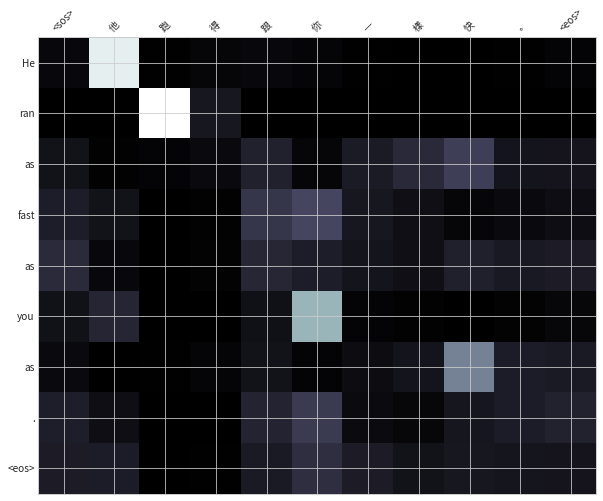

In [25]:
src = [cmn_vocab.itos[idx] for idx in test_data[sample_index][0]]

print ("".join(src) , encoder_decoder_attention.shape)

plot_attention_summary(['<sos>']+src+['<eos>'], translation , encoder_decoder_attention)

## [作業重點] 繪製 encoder and decoder attention 
- encoder_decoder_attention 是 transformer decoder 最後一層的attention 值
- 把八個 attention 分開繪製
- 來原句前後要加 sos and eos

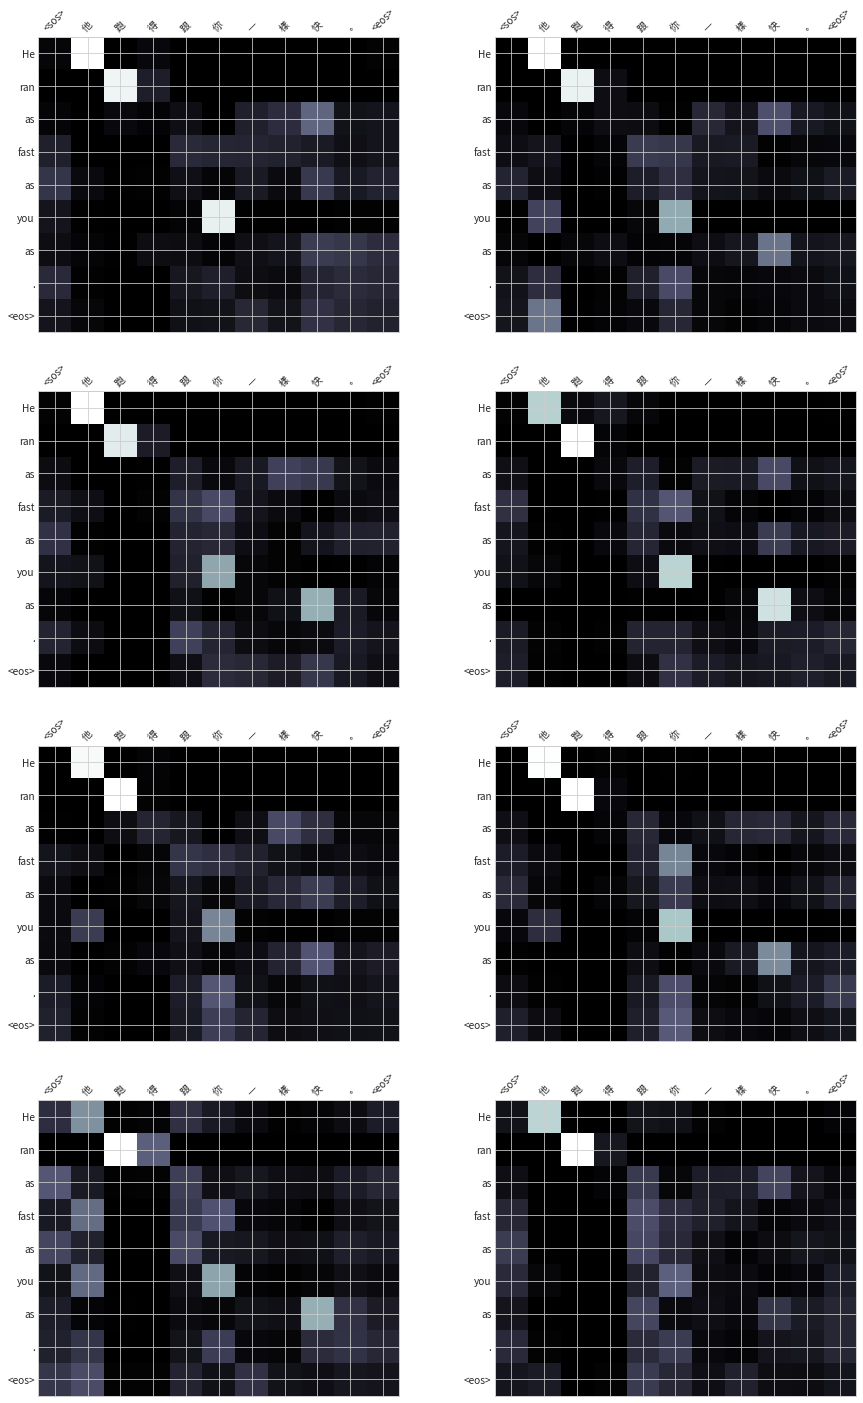

In [26]:
plot_attention(['<sos>']+src+['<eos>'], translation, encoder_decoder_attention)

# [作業重點] 繪製 encoder self attention 
- encoder_self_attention 是 transformer encoder 最後一層的 self attention 值
- Summary 是把 8 個 attention head 的結果累加
- 來原句前後要加 sos and eos

他跑得跟你一樣快。 torch.Size([1, 8, 11, 11])


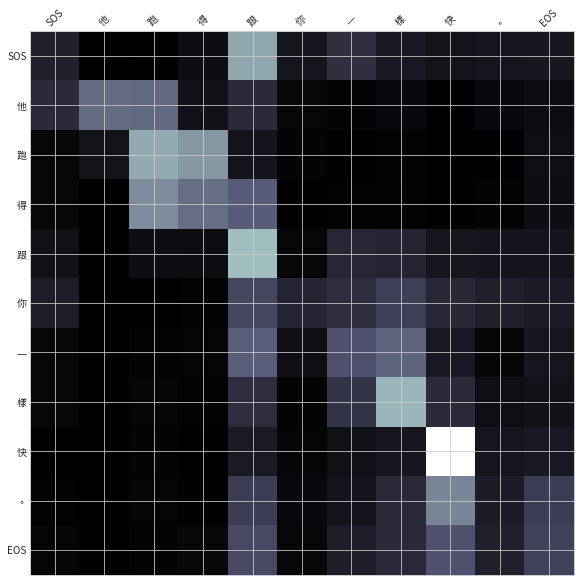

In [27]:
print ("".join(src), encoder_self_attention.shape)

plot_attention_summary(['SOS'] + src + ['EOS'] , ['SOS'] + src + ['EOS'],  encoder_self_attention)

## [作業重點] 繪製 encoder self attention 
- encoder_self_attention 是 transformer encoder 最後一層的 self attention 值
- 把八個 attention 分開繪製
- 來源句前後要加 sos and eos

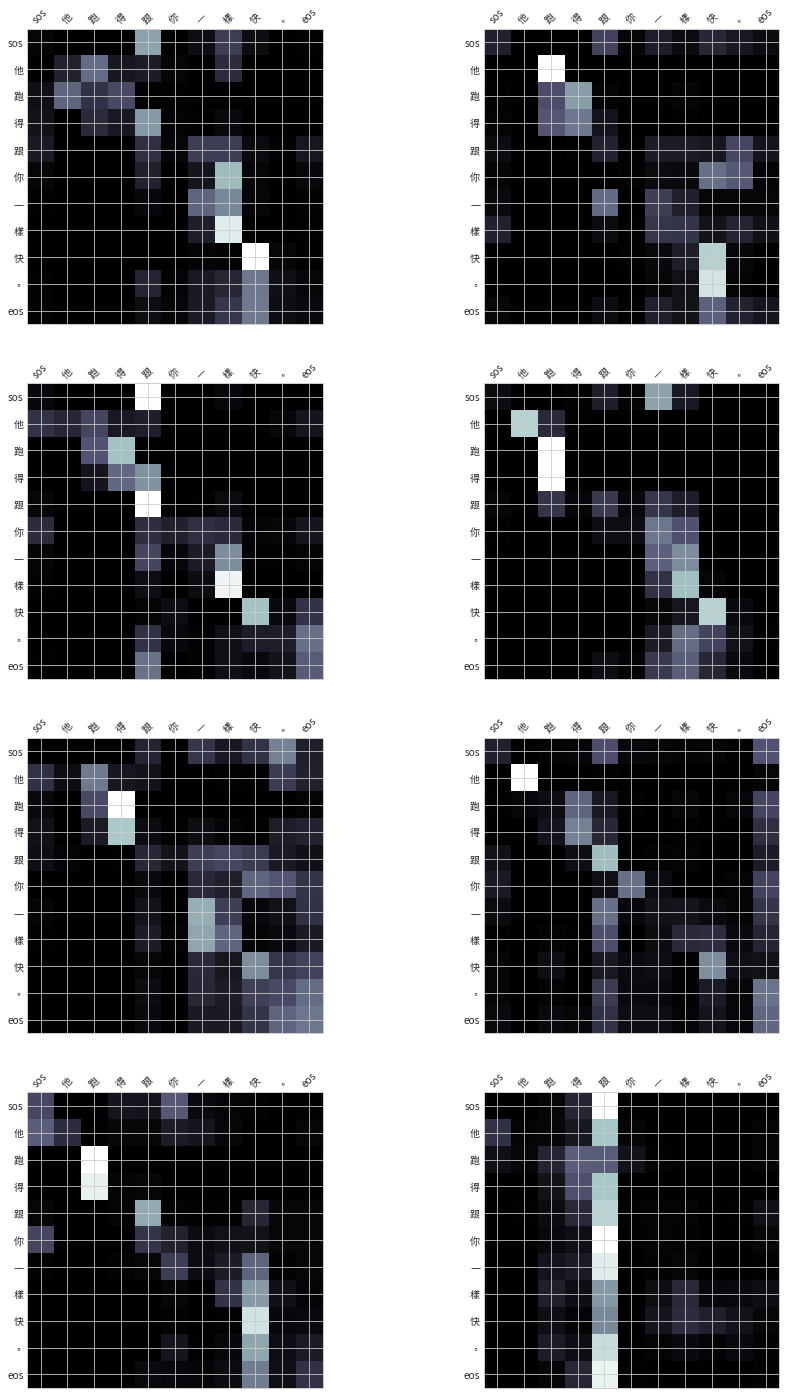

In [28]:
plot_attention(['sos'] + src + ['eos'] , ['sos'] + src + ['eos'] , encoder_self_attention)

## [作業重點] 繪製 decoder self attention 
- decoder_self_attention 是 transformer decoder 最後一層的 self attention 值
- Summary 是把 8 個 attention head 的結果累加
- 被attention 的翻譯句 前要加 sos

他跑得跟你一樣快。 torch.Size([1, 8, 9, 9])


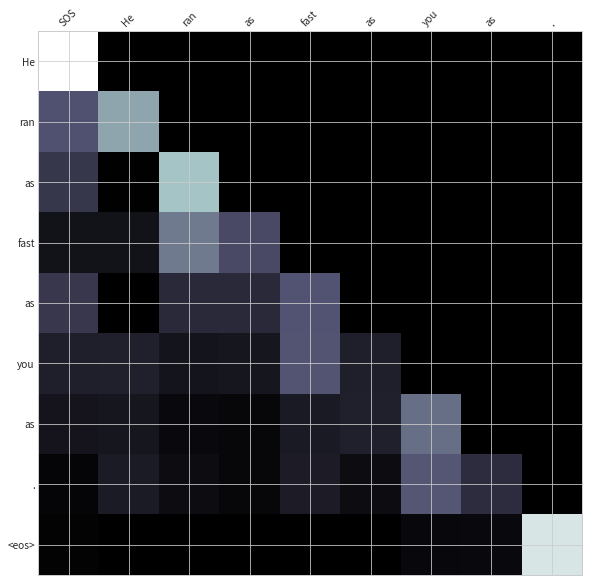

In [29]:
print ("".join(src ), decoder_self_attention.shape)

plot_attention_summary(['SOS'] + translation, translation, decoder_self_attention)


## [作業重點] 繪製 decoder self attention 
- decoder_self_attention 是 transformer decoder 最後一層的 self attention 值
- 把八個 attention heads 分開繪製
- 被attention 的翻譯句 前要加 sos

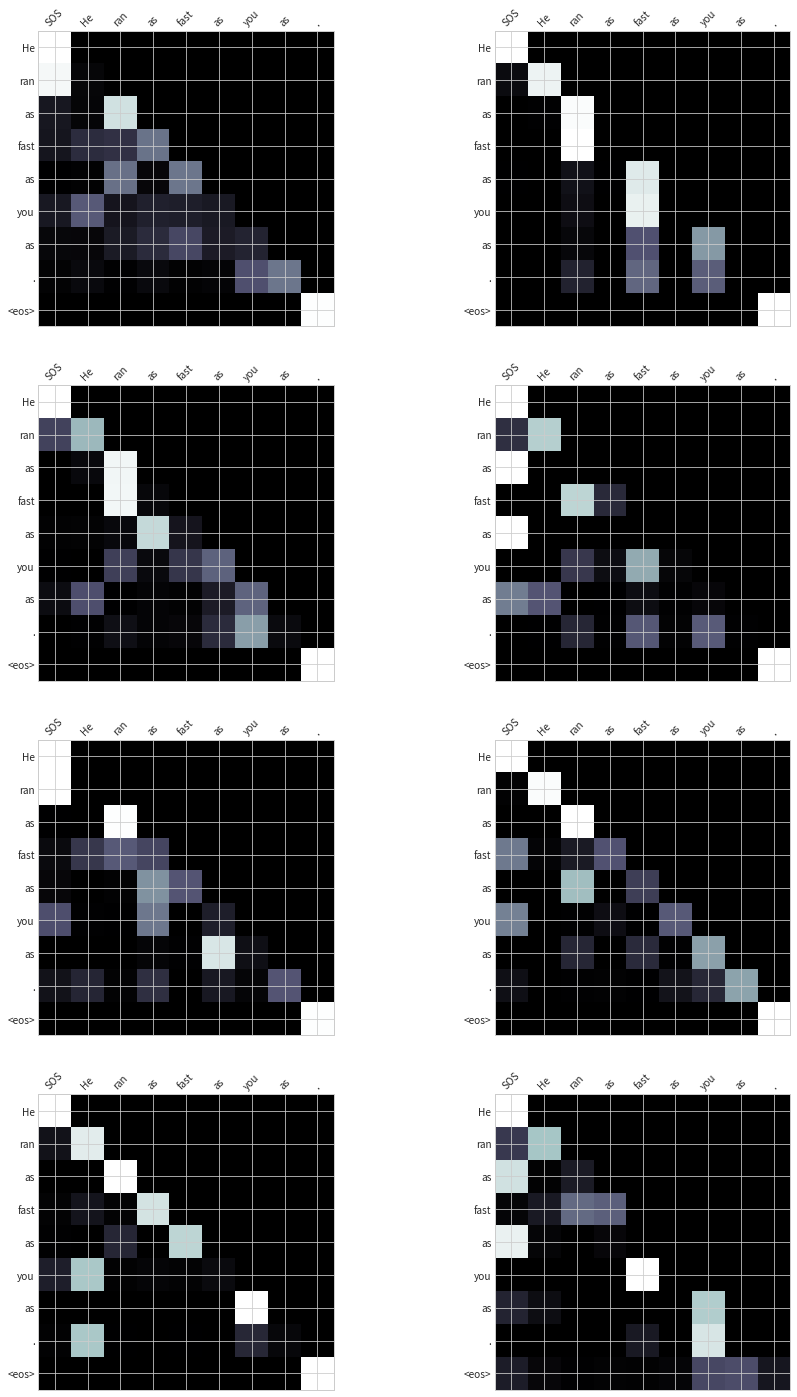

In [30]:
plot_attention(['SOS'] + translation, translation, decoder_self_attention)